# Examine relationships between behavioral measures

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)

## Load behavioral data

In [2]:
struct_raw = tasks.load_struct(bids_dir)
induct_raw = tasks.load_induct(bids_dir)
parse_raw = tasks.load_parse(bids_dir)
group_raw = tasks.load_group(bids_dir)

## Calculate summary statistics

In [3]:
# d' for rotation detection
struct = tasks.exclude_struct_switched(struct_raw)
rot = struct.groupby('subject').apply(tasks.rotation_perf)
m_rot = rot[['dprime']]

In [4]:
# mean difference in parsing probability between transition objects and other objects
parse_raw = tasks.score_parse(parse_raw)
parse = tasks.parse_perf(parse_raw)
table = (
    parse.sort_values(['trial_type', 'subject', 'parse_type'])
    .set_index(['trial_type', 'subject', 'parse_type'])
    .loc[:, 'response']
    .unstack('parse_type')
)
diff = table['transition'] - table['other']
m_parse = diff.unstack('trial_type').mean(axis=1)
m_parse.name = 'parse'

In [5]:
# temporal bias in inference decisions
induct = tasks.score_induct(induct_raw)
m_induct = (
    induct.groupby(['trial_type', 'subject'])['correct']
    .mean()
    .unstack('trial_type')
)
m_induct.columns = m_induct.columns.values.to_list()
m_induct['induct'] = m_induct.mean(axis=1)
m_bias = (m_induct - 0.5) * 2
m_bias['induct'] = m_bias.mean(axis=1)

In [6]:
# group task distances
group = tasks.group_distance(group_raw)
m_group = group.set_index('subject')
m_group['group'] = m_group['across'] - m_group['within']

In [7]:
results = pd.concat([m_rot, m_bias, m_parse, m_group], axis=1)
results.head()

,dprime,central,boundary1,boundary2,induct,parse,within,across,overall,group
subject,,,,,,,,,,
100,4.302244,-0.310345,-0.333333,0.333333,-1.034483e-01,0.112128,6.453109,6.303163,6.348147,-0.149946
101,3.707007,0.066667,0.333333,0.000000,1.333333e-01,0.209351,3.275216,7.544530,6.263736,4.269313
102,3.919636,0.733333,0.666667,0.333333,5.777778e-01,0.702920,1.903457,13.488641,10.013086,11.585184
103,3.474023,0.200000,0.000000,0.333333,1.777778e-01,-0.122795,5.924018,6.538673,6.354276,0.614655
104,3.804131,0.000000,-0.333333,0.333333,-2.775558e-17,0.100037,6.119553,5.797296,5.893973,-0.322257


## Parsing and grouping

In [8]:
pg.partial_corr(data=results, x='parse', y='within', covar='dprime')

,n,r,CI95%,p-val
pearson,37,-0.628091,"[-0.79, -0.38]",0.000041


In [9]:
pg.partial_corr(data=results, x='parse', y='across', covar='dprime')

,n,r,CI95%,p-val
pearson,37,0.065365,"[-0.27, 0.39]",0.704869


In [10]:
pg.corr(results['parse'], results['within'])

,n,r,CI95%,p-val,BF10,power
pearson,37,-0.632519,"[-0.79, -0.39]",0.000027,984.809,0.992559


In [11]:
pg.corr(results['parse'], results['across'])

,n,r,CI95%,p-val,BF10,power
pearson,37,0.052146,"[-0.28, 0.37]",0.759216,0.214,0.0605


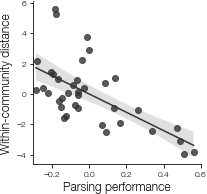

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))
temp = results.copy()
temp['within_ctrl_dprime'] = tasks.resid(results['dprime'], results['within'])
temp['parse_ctrl_dprime'] = tasks.resid(results['dprime'], results['parse'])
sns.regplot(
    data=temp,
    x='parse_ctrl_dprime',
    y='within_ctrl_dprime',
    color=(.2, .2, .2),
    ax=ax,
);
ax.set(
    xlim=(-.3, .6),
    xlabel='Parsing performance',
    ylabel="Within-community distance",
);
fig.savefig(os.path.join(fig_dir, 'parse_within.pdf'))

## Parsing and inference

In [13]:
pg.partial_corr(data=results, x='parse', y='induct', covar='dprime')

,n,r,CI95%,p-val
pearson,37,0.336279,"[0.01, 0.6]",0.044932


In [14]:
pg.corr(results['parse'], results['induct'])

,n,r,CI95%,p-val,BF10,power
pearson,37,0.326069,"[0.0, 0.59]",0.048893,1.324,0.51446


In [15]:
pg.corr(results['parse'], results['induct'])

,n,r,CI95%,p-val,BF10,power
pearson,37,0.326069,"[0.0, 0.59]",0.048893,1.324,0.51446


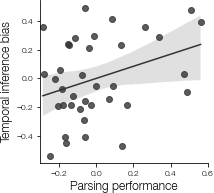

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
temp = results.copy()
temp['induct_ctrl_dprime'] = tasks.resid(results['dprime'], results['induct'])
temp['parse_ctrl_dprime'] = tasks.resid(results['dprime'], results['parse'])
sns.regplot(
    data=temp,
    x='parse_ctrl_dprime',
    y='induct_ctrl_dprime',
    color=(.2, .2, .2),
    ax=ax,
);
ax.set(
    xlim=(-.3, .6),
    xlabel="Parsing performance",
    ylabel="Temporal inference bias",
);
fig.savefig(os.path.join(fig_dir, 'parse_bias.pdf'))

## Grouping and inference

In [17]:
pg.partial_corr(data=results, x='within', y='induct', covar='dprime')

,n,r,CI95%,p-val
pearson,37,-0.184636,"[-0.48, 0.15]",0.281024


In [18]:
pg.partial_corr(data=results, x='across', y='induct', covar='dprime')

,n,r,CI95%,p-val
pearson,37,0.070687,"[-0.26, 0.39]",0.682049


In [19]:
pg.partial_corr(data=results, x='within', y='central', covar='dprime')

,n,r,CI95%,p-val
pearson,37,-0.238957,"[-0.53, 0.1]",0.160446


In [20]:
pg.partial_corr(data=results, x='within', y='boundary1', covar='dprime')

,n,r,CI95%,p-val
pearson,37,-0.075585,"[-0.39, 0.26]",0.661292


In [21]:
pg.partial_corr(data=results, x='within', y='boundary2', covar='dprime')

,n,r,CI95%,p-val
pearson,37,-0.143879,"[-0.45, 0.19]",0.402494


In [22]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.28.0

pandas    : 1.3.3
matplotlib: 3.4.3
pingouin  : 0.4.0
tesser    : 1.0.0
seaborn   : 0.11.2

